<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Analysis</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [195]:
# import block

# own functions
from common_functions import confirm_execution, read_comment_df, read_video_df

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# h1
from scipy.stats import chi2_contingency

In [55]:
# overarching functions

def row_share(df : pd.DataFrame) -> pd.DataFrame:
    """Given a df with numeric values, converts all entries to the share of the row: cell = cell/sum(row)

    Args:
        df (pd.DataFrame): df with numeric columns only

    Returns:
        pd.DataFrame: df with the cells converted
    """
    return df.div(df.sum(axis = 1), axis = 0)

# overarching variables
phase_labels = ["before", "1st spike", "2nd spike", "after"]

# 7. Conduct statistical analysis to test the hypotheses above.

## 7.1 Videos produced before the first spike in public interest are more likely to be non-conspirative compared to those uploaded during and after the spike.

H0: Videos produced before the first spike in public interest are less or equally likely to be non-conspirative compared to those uploaded during and after the spike.

To test the hypothesis, i will need to test for statistical independence of two categorical variables: conspirative and phase. Thus, a Chi-Square test will be applied.

In [56]:
# load relevant data

video_df = read_video_df()

In [57]:
# create contingency table

h1_contingency = pd.crosstab(video_df["phase"],video_df["conspirative_auto"], margins = False)
h1_contingency

conspirative_auto,False,True
phase,,
0,182,88
1,311,880
2,184,370
3,440,488


In [58]:
h1_shares = row_share(h1_contingency)

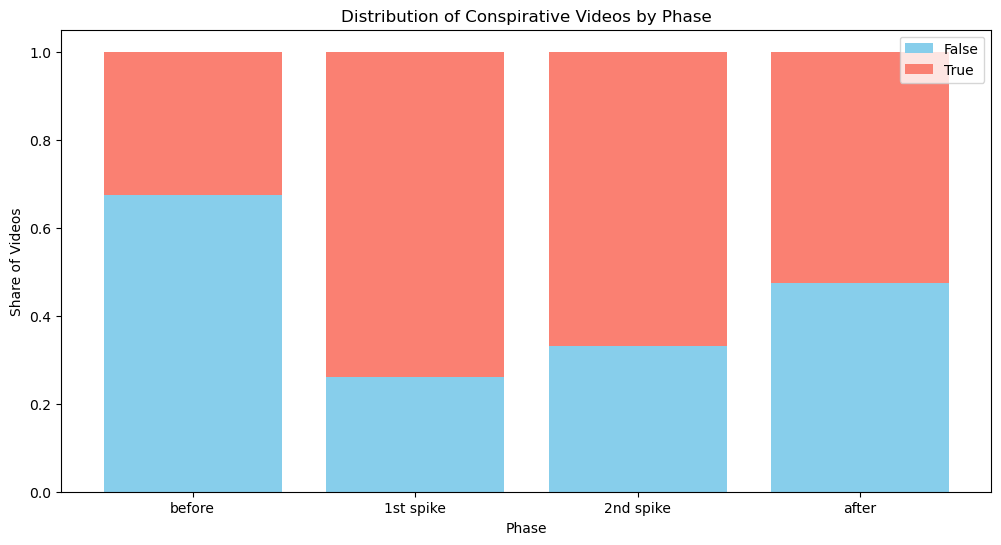

In [59]:
# plot share of conspirative videos per phase
plt.figure(figsize = (12, 6))
plt.bar(phase_labels, h1_shares[False], label = "False", color = "skyblue")
plt.bar(phase_labels, h1_shares[True], bottom = h1_shares[False], label = "True", color = "salmon")

# Labels and title
plt.xlabel("Phase")
plt.ylabel("Share of Videos")
plt.title("Distribution of Conspirative Videos by Phase")
plt.legend()

# Show plot
plt.show()

In [60]:
h1_chi2, h1_p, h1_dof, h1_expected = chi2_contingency(h1_contingency)
h1_expected = pd.DataFrame(h1_expected, index = h1_contingency.index, columns = h1_contingency.columns)

print("Chi-square statistic:", h1_chi2)
print("p-value:", h1_p)
print("Expected distributions under h0: \n", h1_expected)

Chi-square statistic: 210.93240934076437
p-value: 1.8309036247353845e-45
Expected distributions under h0: 
 conspirative_auto       False       True 
phase                                    
0                  102.477064  167.522936
1                  452.037717  738.962283
2                  210.267754  343.732246
3                  352.217465  575.782535


We can already observe that it is extremely unlikely that all 4 phases belong to the same distribution. 

In [61]:
# print percent deviations from expected when assuming independence

h1_shares - row_share(h1_expected)

conspirative_auto,False,True
phase,,
0,0.294529,-0.294529
1,-0.118420,0.118420
2,-0.047415,0.047415
3,0.094593,-0.094593


Once again, clear deviations between the phases are obvious. Most importantly, phase 0 (before the first spike) has significantly less conspirative videos than the other phases, further strengthening the hypothesis.

In [62]:
# finally, re-compute chi square with phase 1, 2, 3 grouped
h1_group_cont = pd.DataFrame({colname : [h1_contingency.iloc[0][colname], h1_contingency.iloc[1:][colname].sum()] for colname in h1_contingency.columns})
h1_group_cont

,False,True
0,182,88
1,935,1738


In [63]:
h1_group_chi2, h1_group_p, h1_group_dof, h1_group_expected = chi2_contingency(h1_group_cont)
h1_group_expected = pd.DataFrame(h1_group_expected, index = h1_group_cont.index, columns = h1_group_cont.columns)

print("Chi-square statistic:", h1_group_chi2)
print("p-value:", h1_group_p)
print("Expected distributions under h0: \n", h1_group_expected)

Chi-square statistic: 108.1335440941017
p-value: 2.512648199037469e-25
Expected distributions under h0: 
          False        True 
0   102.477064   167.522936
1  1014.522936  1658.477064


We once again observe a significant difference between "before the spike" and "during / after the spikes". Additionally, the difference is in line with our hypothesis: The share of conspirative videos in phases 1-3 is higher than expected under statistical independence and lower than expected for phase 0. Based on the results of this analysis, we can confidently reject the null hypothesis.

## 7.2. Comments under conspirative videos express higher levels of negative sentiment compared to comments under non-conspirative videos.

H0: Comments under conspirative videos express lower or the same levels of negative sentiment compared to comments under non-conspirative videos.

In [64]:
# load relevant data
video_df = read_video_df()
comment_df = read_comment_df()

In [65]:
# create merged df with conspirative label and mood

h2_df = pd.merge(comment_df, video_df["conspirative_auto"], left_on = "video_id", right_index = True)

h2_df.sample(3) # using sample to show different video ids

,phase,week_start,video_id,text,label_leia,conspirative_auto
comment_id,,,,,,
Ugzmr_YqpYTQZA4qWNF4AaABAg,2,2023-08-27,lOoC3THEED4,Good morning Pinball!,Happiness,True
UgzQZPN9FAtJDm4kv0p4AaABAg,2,2023-07-30,DUCOQ2d_rOE,"Looks like government subsidized housing, aka ...",Anger,False
Ugw-pZsboCfztSV5Ne14AaABAg,2,2023-07-02,uIFkEQ8jnFE,I'm south Asian myself. But it is sad to say t...,Anger,True


In [66]:
h2_contingency = pd.crosstab(h2_df["conspirative_auto"], h2_df["label_leia"], margins = False)
h2_contingency

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,6330,23998,7754,6788,3691
True,20916,91396,19048,15689,8483


In [125]:
h2_shares = row_share(h2_contingency)
h2_shares = h2_shares[["Happiness", "Affection", "Sadness", "Anger", "Fear"]]
h2_shares

label_leia,Happiness,Affection,Sadness,Anger,Fear
conspirative_auto,,,,,
False,0.139783,0.130352,0.076007,0.494183,0.159675
True,0.100873,0.134480,0.054542,0.587635,0.122470


In [128]:
# add grouped version

h2_group_shares = pd.DataFrame({
    'Positive': h2_shares[['Affection', 'Happiness']].sum(axis=1),
    'Negative': h2_shares[['Anger', 'Fear', 'Sadness']].sum(axis=1)
}, index = h2_shares.index)

h2_group_shares

,Positive,Negative
conspirative_auto,,
False,0.270134,0.729866
True,0.235353,0.764647


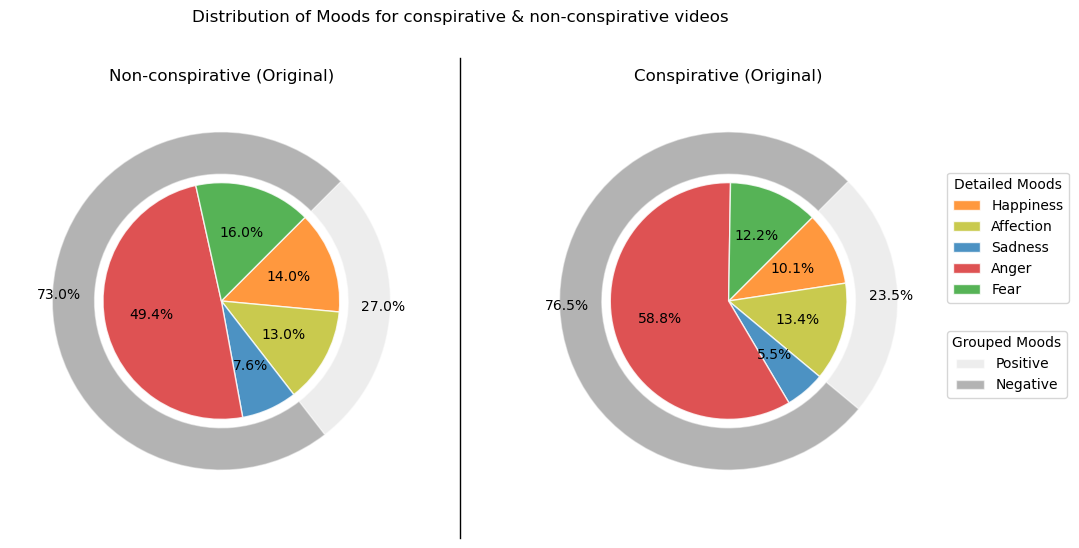

In [194]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

mood_colors = {"Affection" : "#bcbd22", 
               "Anger" : "#d62728", 
               "Fear" : "#2ca02c", 
               "Happiness" : "#ff7f0e", 
               "Sadness" : "#1f77b4", 
               "Positive" : "gainsboro", 
               "Negative" : "dimgrey"}

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Plot the original sentiment shares
for i, row in enumerate(h2_shares.index):
    # Original sentiment pie
    wedges_inner, texts_inner, autotexts_inner = ax[i].pie(h2_shares.loc[row], 
                          colors=[mood_colors[label] for label in h2_shares.columns], 
                          autopct="%1.1f%%", 
                          startangle=45, 
                          counterclock=False,
                          radius=0.7, 
                          wedgeprops=dict(edgecolor='w', linewidth=1, alpha=0.8))
    
    # Overlay grouped sentiment pie
    wedges_outer, texts_outer, autotexts_outer = ax[i].pie(h2_group_shares.loc[row], 
              colors=[mood_colors[label] for label in h2_group_shares.columns], 
              autopct="%1.1f%%", 
              startangle=45, 
              counterclock=False,
              radius=1,
              wedgeprops=dict(width=0.25, edgecolor='w', linewidth=1, alpha=0.5))
    
    # Move the outer layer text further away from the center
    for text in autotexts_outer:
        text.set_verticalalignment('center')
        text.set_horizontalalignment('center')
        # Adjust text position further away from center
        text.set_x(text.get_position()[0] * 1.6)  # Increase or decrease the multiplier to move text further
    
    # Set title
    ax[i].set_title(f"{'Conspirative' if row else 'Non-conspirative'} (Original)")

# Add a single legend on the first subplot
ax[1].legend(wedges_inner, h2_shares.columns, title="Detailed Moods", loc="center left", bbox_to_anchor=(1, 0.15, 0.5, 1))
ax[0].legend(wedges_outer, h2_group_shares.columns, title="Grouped Moods", loc="center left", bbox_to_anchor=(2.2, -0.15, 0.5, 1))

# Add separation line
line = plt.Line2D((.5, .5), (.1, .9), color="k", linewidth=1)
fig.add_artist(line)

# Adjust layout
plt.suptitle("Distribution of Moods for conspirative & non-conspirative videos")

# Show plot
plt.show()


We first conduct some analysis on the detailed moods.

In [198]:
# chi squared test

h2_chi2, h2_p, h2_dof, h2_expected = chi2_contingency(h2_contingency)
h2_expected = pd.DataFrame(h2_expected, index = h2_contingency.index, columns = h2_contingency.columns)

print("Chi-square statistic:", h2_chi2)
print("p-value:", h2_p)
print("Expected distributions under h0: \n", h2_expected)

Chi-square statistic: 1761.0159619007134
p-value: 0.0
Expected distributions under h0: 
 label_leia            Affection         Anger         Fear     Happiness  \
conspirative_auto                                                          
False               6482.794638  27456.346048   6377.15121   5348.079537   
True               20763.205362  87937.653952  20424.84879  17128.920463   

label_leia             Sadness  
conspirative_auto               
False              2896.628566  
True               9277.371434  


In [199]:
h2_shares - row_share(h2_expected)

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,-0.003146,-0.071217,0.028353,0.029652,0.016358
True,0.000982,0.022236,-0.008853,-0.009258,-0.005107


Text(45.722222222222214, 0.5, 'Is video conspirative?')

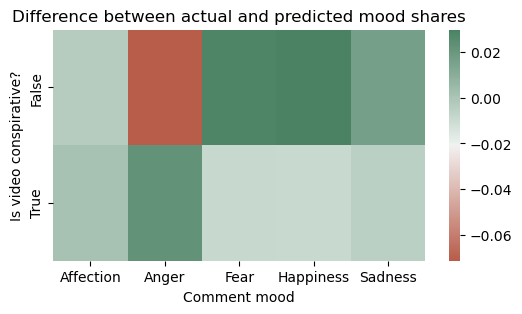

In [214]:
plt.figure(figsize = (6, 3))
sns.heatmap(h2_shares - row_share(h2_expected), cmap = sns.diverging_palette(20, 145, s=60, as_cmap=True))
plt.title("Difference between actual and predicted mood shares")
plt.xlabel("Comment mood")
plt.ylabel("Is video conspirative?")

The plot reveals an important insight: Conspirative videos 

## 7.3. The engagement metrics (e.g., likes, comments, shares per view) of conspirative videos differ significantly from those of non-conspirative videos, with conspirative videos having higher engagement rates per view.